# 🚜 Predicting the Sale Price of Bulldozers

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle [Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

There are 3 main datasets:

* `Train.csv` is the training set, which contains data through the end of 2011.
* `Valid.csv` is the validation set, which contains data from January 1, 2012 - April 30, 2012.
* `Test.csv` is the test set, which contains data from May 1, 2012 - November 2012.

## 3. Evaluation

The evaluation metric for this competition is the **RMSLE (root mean squared log error)** between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Data Dictionary Path: `.\data\bluebook-for-bulldozers\Data Dictionary.xlsx`



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [4]:
# import training and validation sets

df = pd.read_csv(
    'data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)



In [5]:
df.info()
# note: pay attention to sale date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.isna().sum()
# quite a few missing values

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

<Axes: ylabel='Frequency'>

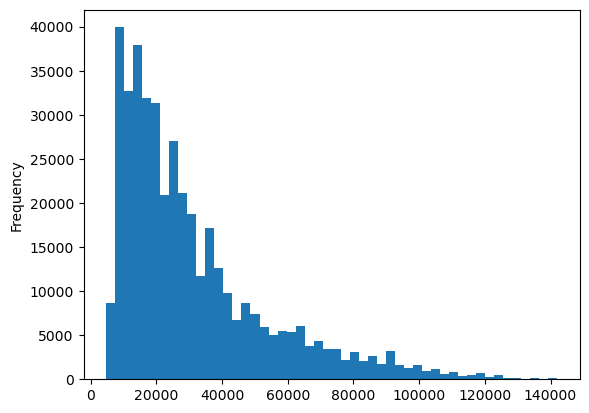

In [9]:
fig, ax = plt.subplots()
df.SalePrice.plot.hist(ax=ax, bins=50)

### Parsing Dates

When working with time series data, we want to enrich the time & date component as much as possible.

- let pandas know which of our columns has dates in it using the `parse_dates` parameter.

In [12]:
# check saledate datatype
df.saledate[:10], df.saledate.dtype

(0    11/16/2006 0:00
 1     3/26/2004 0:00
 2     2/26/2004 0:00
 3     5/19/2011 0:00
 4     7/23/2009 0:00
 5    12/18/2008 0:00
 6     8/26/2004 0:00
 7    11/17/2005 0:00
 8     8/27/2009 0:00
 9      8/9/2007 0:00
 Name: saledate, dtype: object,
 dtype('O'))

In [13]:
# reimport data with parse_dates
df = pd.read_csv(
    'data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [14]:
df.saledate[:10], df.saledate.dtype

(0   2006-11-16
 1   2004-03-26
 2   2004-02-26
 3   2011-05-19
 4   2009-07-23
 5   2008-12-18
 6   2004-08-26
 7   2005-11-17
 8   2009-08-27
 9   2007-08-09
 Name: saledate, dtype: datetime64[ns],
 dtype('<M8[ns]'))

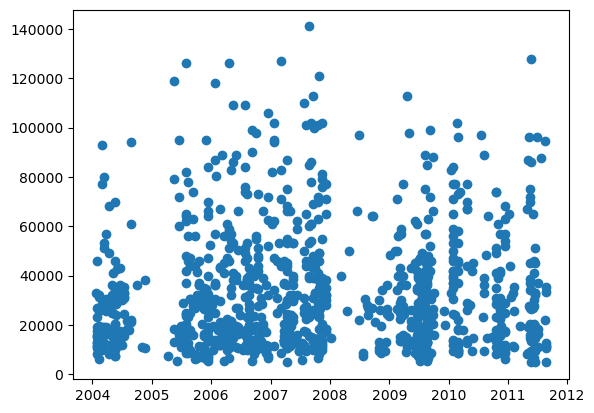

In [15]:
# matplotlib can now recognize the date datatype and plot it
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

In [16]:
# sort dataframe by saledate
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [17]:
# make a copy so we dont have to worry about messing up the original data
df_tmp = df.copy()

## Feature Engineering

In [18]:
# add datetime parameters for saledate column

df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

# now we can drop saledate
df_tmp.drop('saledate', axis=1, inplace=True)

In [19]:
# check values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

Start by converting data into numbers
- use pd categories to convert data into numbers
- fill missing values
- build a machine learning model on our data
    - random forest regressor
    - xgboost regressor?

In [35]:
# Find all columns with string datatype

for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)


UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [36]:
# convert all string values to categories
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [37]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [39]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

All objects/string data types have been converted into numbers.
Next step is to fill missing values.

In [42]:
# check missing data
missing = df_tmp.isna().sum()/len(df_tmp)
missing[missing > 0]

auctioneerID                0.048791
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
Blade_Extension             0.937041
Blade_Width                 0.937041
Enclosure_Type              0.937041
Engine_Horsepower           0.937041
Hydraulics                  0.200062
Pushblock                   0.937041
Ripper                      0.740864
Scarifier                   0.937014
Tip_Control                 0.937041
Tire_Size                   0.763415
Coupler                     0.465277
Coupler_System              0.891024
G

In [43]:
# save preprocessed data
# df_tmp.to_csv('data/bluebook-for-bulldozers/train_tmp.csv',
#               index=False)

In [44]:
# import preprocessed data
df_tmp = pd.read_csv('data/bluebook-for-bulldozers/train_tmp.csv',
                     low_memory=False)

## Fill Missing Values

1. Fill numerical missing values first
2. Fill categorical missing values with `pandas categories` & `pd.get_dummies()`

In [47]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())


In [48]:
# check if there's any missing numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)


In [51]:
# fill categorical missing data and turn categories into numbers
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(
            content).codes+1

In [58]:
# confirm all missing data is filled
missing_items = df_tmp.isna().sum()
missing_items[missing_items > 0]


Series([], dtype: int64)

All data is numeric and no missing values!

## Time to fit a model on our data

In [60]:
# this is the baseline model
# %%time took 11 min 
from sklearn.ensemble import RandomForestRegressor
# instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# fit the model

# model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp.SalePrice)

# score the model
# model.score(df_tmp.drop('SalePrice', axis=1), df_tmp.SalePrice)

# Note: not reliable. didnt split data into train and validation sets

0.9875468079970562